# Loading and correcting data for RhFe 
# P22 beamtime  in November 2018

In [67]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
# Embedded imports
import os, sys
import math
import matplotlib.pyplot as plt
# Third party imports
import numpy as np
import pandas as pd
import scipy as sp
# Temporary solution for local imports
sys.path.append('..')
from xpstool import scientahandler as scih
from xpstool import specshandler as speh
from xpstool import background as bg
from xpstool import fitter
from xpstool import Region

In [3]:
# Constants
p22_energy_3800 = 3800 # Photon energy from the p22 beamline
p22_energy_4600 = 4600 # Photon energy from the p22 beamline
min_info = [
    "Region Name",
    "Pass Energy",
    "Number of Sweeps",
    "Energy Step",
    "Date",
    "Time",
    "File"
]

In [4]:
# ---SCIENTA DATA---
# Full path to data files
data_folder = "/Users/Shipilin/Documents/07_DataAnalysis/2018-RhFe_alloys/2018-November_Rh80Fe20/2018-11_Beamtime/Data"
# Full path to output files
output_folder = "/Users/Shipilin/Documents/07_DataAnalysis/2018-RhFe_alloys/2018-November_Rh80Fe20/2018-11_Beamtime/ProcessedData"

file_names = []
file_idx = 0
for file in sorted(os.listdir(data_folder)):
    if file.endswith(".txt"):                         
        file_names.append(file)
        print(f"---> file[{file_idx}]: {file}")
        file_idx += 1

---> file[0]: 0000.txt
---> file[1]: 0001.txt
---> file[2]: 0002.txt
---> file[3]: 0003.txt
---> file[4]: 0004.txt
---> file[5]: 0005.txt
---> file[6]: 0006.txt
---> file[7]: 0007.txt
---> file[8]: 0008.txt
---> file[9]: 0009.txt
---> file[10]: 0010.txt
---> file[11]: 0011.txt
---> file[12]: 0012.txt
---> file[13]: 0013.txt
---> file[14]: 0014.txt
---> file[15]: 0015.txt
---> file[16]: 0016.txt
---> file[17]: 0017.txt
---> file[18]: 0018.txt
---> file[19]: 0019.txt
---> file[20]: 0020.txt
---> file[21]: 0021.txt
---> file[22]: 0022.txt
---> file[23]: 0023.txt
---> file[24]: 0024.txt
---> file[25]: 0025.txt
---> file[26]: 0026.txt
---> file[27]: 0027.txt
---> file[28]: 0028.txt
---> file[29]: 0029.txt
---> file[30]: 0030.txt
---> file[31]: 0031.txt
---> file[32]: 0032.txt
---> file[33]: 0033.txt
---> file[34]: 0034.txt
---> file[35]: 0035.txt
---> file[36]: 0036.txt
---> file[37]: 0037.txt
---> file[38]: 0038.txt
---> file[39]: 0039.txt
---> file[40]: 0040.txt
---> file[41]: 0041.txt
--

In [5]:
# Loading all regions to a dictionary 
# together with the file names without extensions
# {"filename": region}
regions = {}
regions_total_number = 0
# Storing the names of files with the number of regions
# different from usual 1 in a list [[name, regions_num],..]
dif_files = []

for name in file_names:
    # Adding regions to dictionary with file name without extension as the a key 
    regions_in_name = scih.importScientaFile("/".join([data_folder, name]))
    regions[name.rpartition('.')[0]] = regions_in_name
    # ImportScientaFile returns list with one or more regions
    # we need to loop through it in any case
    if len(regions_in_name) != 1:
        dif_files.append([name, len(regions_in_name)])
    for region in regions_in_name:
        # Adding regions to dictionary with file name without extension
        # as a key
        regions_total_number += 1
        
print(f"{regions_total_number} regions were loaded successfuly.")
print(f"{len(file_names)} files were processed.")

if regions_total_number != len(file_names):
    if regions_total_number > len(file_names):
        print("NOTE! More regions than files.")
    elif regions_total_number < len(file_names):
        print("NOTE! More files than regions.")
    for entry in dif_files:
        print(f"{entry[0]}  :  {entry[1]} regions")


344 regions were loaded successfuly.
348 files were processed.
NOTE! More files than regions.
0049.txt  :  0 regions
0159.txt  :  0 regions
0175.txt  :  0 regions
0317.txt  :  0 regions


**Files from 0000 to 0157 were measured at 4600 eV photon energy**

**File 0158 was measured at 3700 eV photon energy (IGNORE)**

**Files from 0159 to 0347 were measured at 3800 eV photon energy**

## <font color ='blue'>First experiment H2 : CO2 = 1 : 1 at ~50 mbar</font>
CO2 -> 0.3 L/m <br>
H2 -> 0.3 L/m <br>
He -> 0.16 L/m <br>

#### 1. Room temperature <br>
First diff pumping stage pressure 5.6e-4 <br>
Files: <br>
>    Ef_4600 - 0002.txt <br>
    O1s_4600 - 0003.txt <br>
    C1s_4600 - 0004.txt <br>
    Fe2p_4600 - 0005.txt <br>
    Rh3d_4600 - 0007.txt <br>

In [57]:
fermi = regions["0002"][0]
scans = []
for numstr in ["0003", "0004", "0005", "0007"]:
    scans.append(regions[numstr][0])

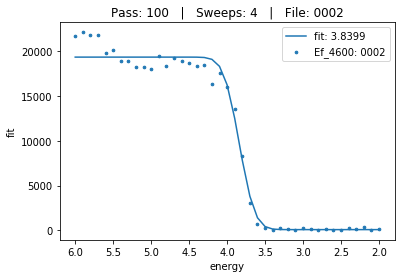

In [62]:
# Loading Fermi region 
fermi.setFermiFlag()
fermi.invertToBinding(p22_energy_4600)
#print(fermi.getInfoString(*min_info))
fermi.plotRegion(1, scatter=True)

fit_parameters = [1, 3.8, 0.2, 20000]
#Fitting and adding a column with the fit function to the region object
shift = fitter.fitFermiEdge(fermi, fit_parameters, add_column=True)[0][1]
fermi.plotRegion(1, y_data="fit", label=f"fit: {shift:.4f}")

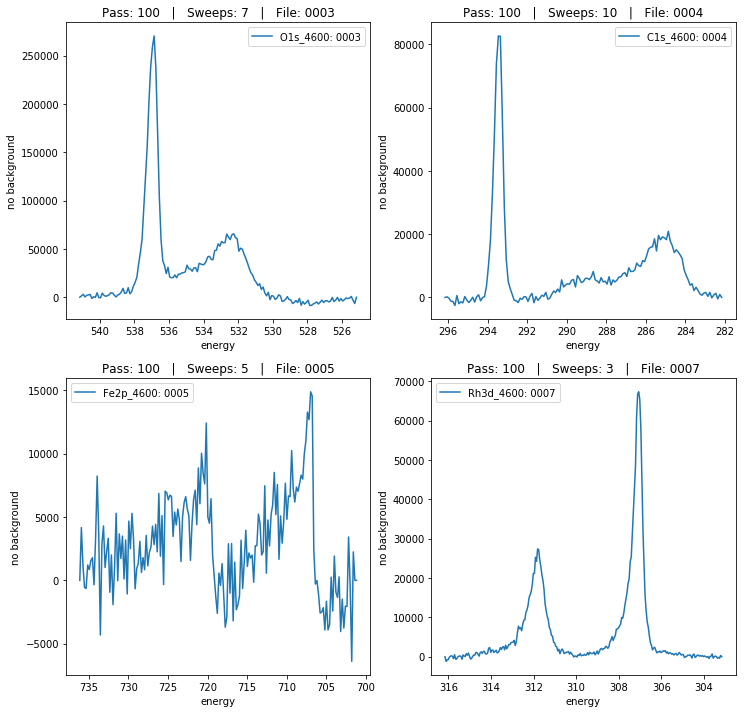

In [61]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
ax = [ax1, ax2, ax3, ax4]
for i, scan in enumerate(scans):
    scan.correctEnergyShift(shift)
    scan.invertToBinding(p22_energy_4600)
    # Subtract Shirley background
    background = bg.calculateShirley(scan, add_column=True)  
    # Plotting spectra with Shirley background subtracted
    scan.plotRegion(figure=fig.number, ax=ax[i], y_data="no background")
    # Plot the background together with the spectra to check its appearance
    #plt.plot(scan.getData()["energy"].values, background, color="gray")

#### 2. 150 C <br>
CO2 -> 0.3 L/m <br>
H2 -> 0.3 L/m <br>
He -> 0.16 L/m <br>
First diff pumping stage pressure 3.3e-4 <br>
Files: <br>
>    Ef_4600 - 0014.txt <br>
    O1s_4600 - 0008.txt <br>
    C1s_4600 - 0011.txt <br>
    Fe2p_4600 - 0013.txt <br>
    Rh3d_4600 - 0012.txt <br>

In [20]:
display(region.getData())

,energy,counts,no background
0,316.160105,9773.0,0.000000e+00
1,316.110105,8617.0,-1.160769e+03
2,316.060105,8983.0,-7.980473e+02
3,316.010105,9042.0,-7.420961e+02
4,315.960105,9647.0,-1.376616e+02
5,315.910105,9911.0,1.268596e+02
6,315.860105,10019.0,2.358284e+02
7,315.810105,9920.0,1.373928e+02
8,315.760105,9315.0,-4.695361e+02
9,315.710105,10295.0,5.125696e+02
